In [1]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms,text_removal,text_reading

# 3rd Party Libraries
from skimage.io import imread
from skimage.color import rgb2gray
from typing import Tuple, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import ml_metrics as metrics
import pytesseract
import re
import textdistance

In [2]:
def denoise_images (images, method='nlmeans', ksize=(3,3)):
    
    (lpfw,lpfh) = ksize
    (gfw,gfh) = ksize
    
    new_images = []
    for img in tqdm(images):
        
        if method == 'low_pass':
            lowPassFilter = np.ones((lpfw,lpfh))*1/(lpfw*lpfh)
            denoised_img = cv2.filter2D(img,-1,lowPassFilter)
        elif method == 'gauss':
            #gaussianFilter = gaussFilter((gfw,gfh),1)
            #gaussian_image = cv2.filter2D(img,-1,gaussianFilter)
            denoised_img = cv2.GaussianBlur(img,ksize,0)

        elif method == 'average':
            denoised_img = cv2.blur(img,ksize)
        
        elif method == 'nlmeans':
            denoised_img = cv2.fastNlMeansDenoisingColored(img, None, 15, 15, 13, 21)
            
        elif method == 'median':
            denoised_img = cv2.medianBlur(img,ksize[0])
        else:
            return None 
        
        new_images.append(denoised_img)
        
    return new_images

In [3]:
data_manager = DataManager()
db, db_files = data_manager.load_data(folder = "./data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")
qsd1_w2, qsd1_w2_files = data_manager.load_data(folder = "./data/qsd1_w2/", extension = ".jpg", desc = "Loading qsd1_w2 Data...")

qsd1_w3, qsd1_w3_files = data_manager.load_data(folder = "./data/qsd1_w3/", extension = ".jpg", desc = "Loading qsd1_w3 Data...")
qsd2_w3, qsd2_w3_files = data_manager.load_data(folder = "./data/qsd2_w3/", extension = ".jpg", desc = "Loading qsd2_w3 Data...")

Loading qsd1_w2 Data...:  53%|█████████████████████████████▊                          | 16/30 [00:00<00:00, 154.26it/s]

./data/BBDD/ read: 287 images


Loading qsd1_w3 Data...: 100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 240.64it/s]

./data/qsd1_w2/ read: 30 images



Loading qsd2_w3 Data...:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/qsd1_w3/ read: 30 images


Loading qsd2_w3 Data...: 100%|█████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.73it/s]


./data/qsd2_w3/ read: 30 images


Bc
. )
d
les
ne
7 )
J I\

 

  
 

 



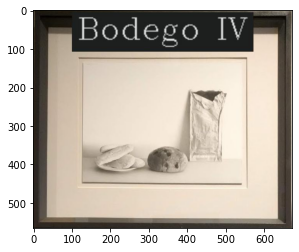

In [4]:

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
text = pytesseract.image_to_string(qsd1_w2[0])
print(text)
plt.imshow(qsd1_w2[0])

In [5]:
BBDD_texts = data_manager.load_text(folder = "./data/BBDD/", extension = ".txt", desc = "Loading BBDD Text...")
print(BBDD_texts)

Loading BBDD Text...: 100%|████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 2378.23it/s]


[('./data/BBDD/bbdd_00000.txt', "('Victor Perez-Porros', 'Des-li-zan-tes')\n"), ('./data/BBDD/bbdd_00001.txt', "('Hugo Demarco', 'Reflecting Room')\n"), ('./data/BBDD/bbdd_00002.txt', '\n'), ('./data/BBDD/bbdd_00003.txt', "('Edvard Munch', 'Youth')\n"), ('./data/BBDD/bbdd_00004.txt', "('Martin Carral', 'Ciclo espacial XXIV')\n"), ('./data/BBDD/bbdd_00005.txt', "('Mario Pasqualotto', 'Els 72 noms de Deu')\n"), ('./data/BBDD/bbdd_00006.txt', "('Gerard Sala', 'S/t')\n"), ('./data/BBDD/bbdd_00007.txt', "('Yago Hortal', 'Kl 45')\n"), ('./data/BBDD/bbdd_00008.txt', "('Josep Guinovart', 'S/t')\n"), ('./data/BBDD/bbdd_00009.txt', '\n'), ('./data/BBDD/bbdd_00010.txt', "('Agusti Puig', 'Sota la lleona')\n"), ('./data/BBDD/bbdd_00011.txt', "('Joan Hernandez Pijuan', 'Serie violetes i verds')\n"), ('./data/BBDD/bbdd_00012.txt', "('Regina Gimenez', 'Navegants')\n"), ('./data/BBDD/bbdd_00013.txt', "('Pere Santilari', 'Berenar de pastisseria')\n"), ('./data/BBDD/bbdd_00014.txt', '\n'), ('./data/BBDD/

In [6]:
BBDD_titles = data_manager.extract_title(data=BBDD_texts,index=1,desc='Extracting titles from DDBB...')
BBDD_authors = data_manager.extract_title(data=BBDD_texts,index=0,desc='Extracting authors from DDBB...')


Extracting authors from DDBB...: 100%|████████████████████████████████████████████| 287/287 [00:00<00:00, 71922.40it/s]


In [7]:
print(BBDD_authors)

['Victor Perez-Porros', 'Hugo Demarco', '', 'Edvard Munch', 'Martin Carral', 'Mario Pasqualotto', 'Gerard Sala', 'Yago Hortal', 'Josep Guinovart', '', 'Agusti Puig', 'Joan Hernandez Pijuan', 'Regina Gimenez', 'Pere Santilari', '', 'Josep Ginovart', 'Corneille', '', '', '', 'Antoni Llena', 'Josep Cisquella', 'Modest Cuixart', 'Per Krohg', 'Joan Pere Viladecans', 'Josep Guinovart', 'Victor Perez-Porro', 'Marco Palazzi', 'Robert Llimos', '', 'Francesca Llopis', 'Pablo Picasso', 'Perejaume', '', 'Jose Luis Pascual', 'Sergi Barnils', '', 'Agusti Puig', '', 'Alfred Figueras', 'Paul Klee', 'Robert Llimos', 'Enrique Barro', 'Narcis Comadira', 'Josep Segu', 'Joan Pere Viladecans', 'Lluis Lleo', 'Xavier Valls', 'Ramiro Fernandez Saus', '', 'Jordi Fulla', 'Alfred Figueras', 'Pere Santilari', 'Alfons Borrell', 'Anna-Eva Bergman', 'Alfons Borrell', '', 'Paul Klee', 'Alfred Figueras', '', 'Jens Ferdinand Willumsen', '', '', 'Edvard Munch', 'Julio Vaquero', '', '', 'Ramon Enrich', 'Jordi Isern', 'Edv

Reading titles from images:   0%|                                                               | 0/30 [00:00<?, ?it/s]

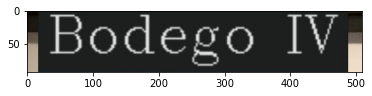

Reading titles from images:   3%|█▊                                                     | 1/30 [00:00<00:08,  3.38it/s]

»sBodego IV,

sBodego IV


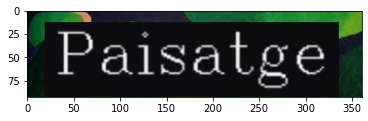

Reading titles from images:   7%|███▋                                                   | 2/30 [00:00<00:08,  3.26it/s]

‘Paisatge

Paisatge


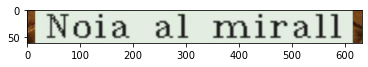

Reading titles from images:  10%|█████▌                                                 | 3/30 [00:01<00:08,  3.04it/s]

‘Noia al mirallj

Noia al mirallj


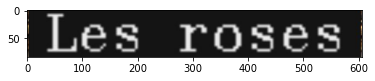

Reading titles from images:  13%|███████▎                                               | 4/30 [00:01<00:08,  2.91it/s]

Les roses

Les roses


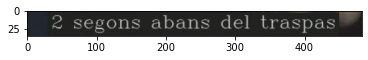

Reading titles from images:  17%|█████████▏                                             | 5/30 [00:01<00:08,  3.00it/s]

2 segons abans del traspas’

2 segons abans del traspas


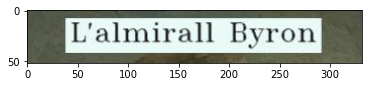

Reading titles from images:  20%|███████████                                            | 6/30 [00:02<00:07,  3.04it/s]

L'ialmirall Byron

Lialmirall Byron


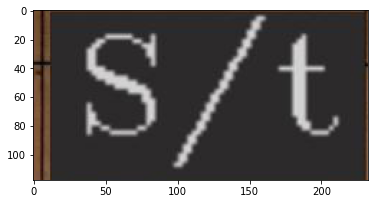

Reading titles from images:  23%|████████████▊                                          | 7/30 [00:02<00:08,  2.87it/s]

iS/t

iSt


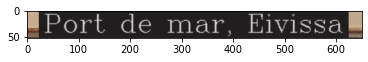

Reading titles from images:  27%|██████████████▋                                        | 8/30 [00:02<00:08,  2.64it/s]

#Port de mar, Eivissa®™

Port de mar Eivissa


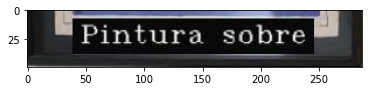

Reading titles from images:  30%|████████████████▌                                      | 9/30 [00:03<00:07,  2.81it/s]

: Pintura sobre Ll

 

 Pintura sobre Ll 


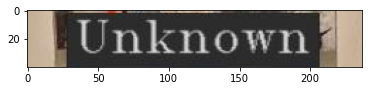

Reading titles from images:  33%|██████████████████                                    | 10/30 [00:03<00:06,  3.06it/s]

7. Unknown a

7 Unknown a


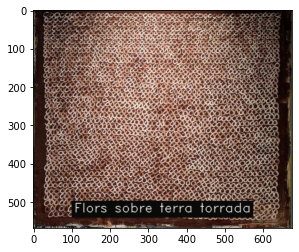

Reading titles from images:  37%|███████████████████▊                                  | 11/30 [00:04<00:08,  2.22it/s]

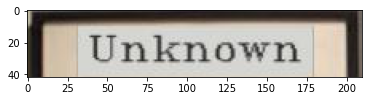

Reading titles from images:  40%|█████████████████████▌                                | 12/30 [00:04<00:07,  2.52it/s]

i Unknown }

i Unknown 


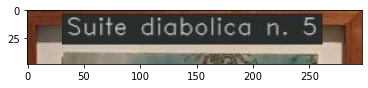

Reading titles from images:  43%|███████████████████████▍                              | 13/30 [00:04<00:06,  2.72it/s]

Suite diabolica n. 5

 

Suite diabolica n 5 


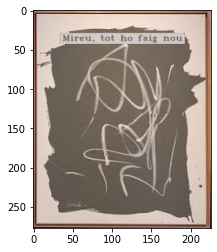

Reading titles from images:  47%|█████████████████████████▏                            | 14/30 [00:05<00:05,  2.87it/s]

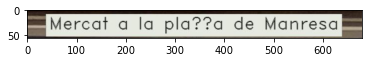

Reading titles from images:  50%|███████████████████████████                           | 15/30 [00:05<00:05,  2.81it/s]

= Mercat a la pla??a de Manresa a

 Mercat a la plaa de Manresa a


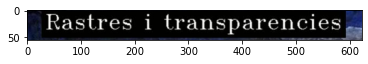

Reading titles from images:  53%|████████████████████████████▊                         | 16/30 [00:05<00:05,  2.75it/s]

Rastres i transparencies .

Rastres i transparencies 


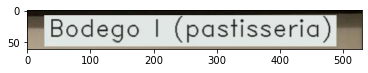

Reading titles from images:  57%|██████████████████████████████▌                       | 17/30 [00:06<00:04,  2.91it/s]

™Bodego | (pastisseria) M™

Bodego  pastisseria M


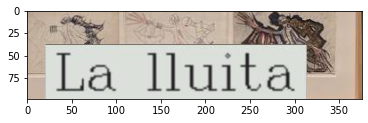

Reading titles from images:  60%|████████████████████████████████▍                     | 18/30 [00:06<00:03,  3.07it/s]

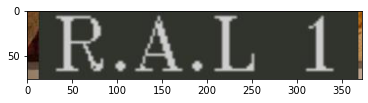

Reading titles from images:  63%|██████████████████████████████████▏                   | 19/30 [00:06<00:03,  3.26it/s]

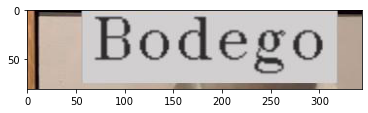

Reading titles from images:  67%|████████████████████████████████████                  | 20/30 [00:06<00:02,  3.38it/s]

| Bodego |

 Bodego 


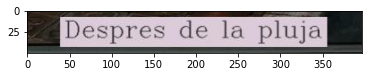

Reading titles from images:  70%|█████████████████████████████████████▊                | 21/30 [00:07<00:02,  3.47it/s]

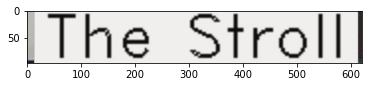

Reading titles from images:  73%|███████████████████████████████████████▌              | 22/30 [00:07<00:02,  3.35it/s]

The Stroll)

The Stroll


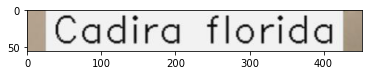

Reading titles from images:  77%|█████████████████████████████████████████▍            | 23/30 [00:07<00:02,  3.48it/s]

Cadira florida

Cadira florida


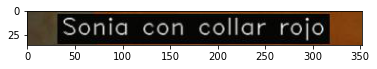

Reading titles from images:  80%|███████████████████████████████████████████▏          | 24/30 [00:08<00:01,  3.13it/s]

Tol al re mmoxe) aimoxe) Kel amt ge) (e)

Tol al re mmoxe aimoxe Kel amt ge e


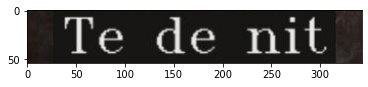

Reading titles from images:  83%|█████████████████████████████████████████████         | 25/30 [00:08<00:01,  3.24it/s]

Te de nit

Te de nit


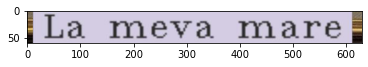

Reading titles from images:  87%|██████████████████████████████████████████████▊       | 26/30 [00:08<00:01,  3.21it/s]

eLa meva mare:

eLa meva mare


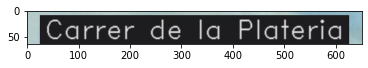

Reading titles from images:  90%|████████████████████████████████████████████████▌     | 27/30 [00:09<00:00,  3.07it/s]

s Carrer de la Plateriall

s Carrer de la Plateriall


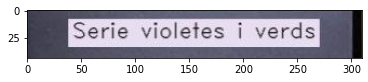

Reading titles from images:  93%|██████████████████████████████████████████████████▍   | 28/30 [00:09<00:00,  3.21it/s]

rie violetes i verds

rie violetes i verds


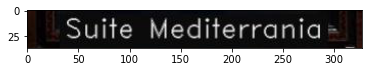

Reading titles from images:  97%|████████████████████████████████████████████████████▏ | 29/30 [00:09<00:00,  3.22it/s]

Suite Mediterrania= |

Suite Mediterrania 


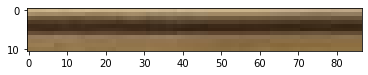

Reading authors from images:   0%|                                                              | 0/30 [00:00<?, ?it/s]

Reading authors from images: 100%|█████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.34it/s]


In [25]:
# Mention the installed location of Tesseract-OCR in your system
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
#qsd2_w3_denoised = denoise_images (qsd2_w3,method='nlmeans', ksize=(3,3))
detected_titles = text_reading(data=qsd1_w2,num_images=1,desc='Reading titles from images')
detected_authors = text_reading(data=qsd2_w3,num_images=2,desc='Reading authors from images')
     

In [26]:
print(detected_titles)
print(detected_authors)

['sBodego IV', 'Paisatge', 'Noia al mirallj', 'Les roses', '2 segons abans del traspas', 'Lialmirall Byron', 'iSt', 'Port de mar Eivissa', ' Pintura sobre Ll ', '7 Unknown a', ' ', 'i Unknown ', 'Suite diabolica n 5 ', ' ', ' Mercat a la plaa de Manresa a', 'Rastres i transparencies ', 'Bodego  pastisseria M', ' ', '', ' Bodego ', ' ', 'The Stroll', 'Cadira florida', 'Tol al re mmoxe aimoxe Kel amt ge e', 'Te de nit', 'eLa meva mare', 's Carrer de la Plateriall', 'rie violetes i verds', 'Suite Mediterrania ', '']
[(' ', '    Perejaume'), (' ', 'Pablo Picasso'), ('Joan Ponc  ', ' Modest Cuixart'), ('    ', ' '), ('     i pconmenmenimemennnenans 5 Sb or nr a wena nana bretao wee        ', ' '), (' Alfons Borrell', ''), ('s Alfred Figueras ', '  5 el atedSS       Alfred Figueras'), ('sAlfred Figuerass', 'Alfred Figueras'), (' ', ''), ('Alfred Figueras F', '-Alfred Figueras'), ('Jodn Hernandez Pijuan ', ' '), (' ', 'Alfred Figueras j'), ('    FJordi Prat jim', '         Jordi Prat'), ('-Al

In [27]:
sim = Similarity()

qsd1_w2_similarities = sim.compute_string_similarities(detected_titles,BBDD_titles,desc='Computing string similarity', similarity='levenshtein')
qsd1_w3_similarities = sim.compute_string_similarities(detected_authors,BBDD_authors,desc='Computing string similarity', similarity='levenshtein')

Computing string similarity: 100%|█████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.59it/s]


In [19]:

top_k_qsd1_w2 = sim.get_top_k(qsd1_w2_similarities, db_files, 10, desc='Extracting top 10')
top_k_qsd1_w3 = sim.get_top_k(qsd1_w3_similarities, db_files, 10, desc='Extracting top 10')

Extracting top 10: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 10026.22it/s]


In [28]:
SAVE_RESULTS =False
K=10
predicted_results_qsd1_w2 = data_manager.save_results_1(results = top_k_qsd1_w2, path = "./week3/QSD1W2/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w2 = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))
predicted_results_qsd1_w3 = data_manager.save_results_1(results = top_k_qsd1_w3, path = "./week3/QSD1W3/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w3 = pickle.load(file = open('./data/qsd2_w3/gt_corresps.pkl', "rb"))

metric = metrics.mapk(actual = expected_results_qsd1_w2, predicted = predicted_results_qsd1_w2, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w2)*metric),len(predicted_results_qsd1_w2)))
metric = metrics.mapk(actual = expected_results_qsd1_w3, predicted = predicted_results_qsd1_w3, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w3)*metric),len(predicted_results_qsd1_w3)))

MAP@10 Score: 67.0000% (20/30)
MAP@10 Score: 1.2222% (0/30)


In [22]:
K=5
predicted_results_qsd1_w2 = data_manager.save_results_1(results = top_k_qsd1_w2, path = "./week3/QSD1W2/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w2 = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))
predicted_results_qsd1_w3 = data_manager.save_results_1(results = top_k_qsd1_w3, path = "./week3/QSD1W3/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w3 = pickle.load(file = open('./data/qsd1_w3/gt_corresps.pkl', "rb"))

metric = metrics.mapk(actual = expected_results_qsd1_w2, predicted = predicted_results_qsd1_w2, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w2)*metric),len(predicted_results_qsd1_w2)))
metric = metrics.mapk(actual = expected_results_qsd1_w3, predicted = predicted_results_qsd1_w3, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w3)*metric),len(predicted_results_qsd1_w3)))

MAP@5 Score: 66.6667% (20/30)
MAP@5 Score: 43.8889% (13/30)


In [23]:
K=1
predicted_results_qsd1_w2 = data_manager.save_results_1(results = top_k_qsd1_w2, path = "./week3/QSD1W2/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w2 = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))
predicted_results_qsd1_w3 = data_manager.save_results_1(results = top_k_qsd1_w3, path = "./week3/QSD1W3/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w3 = pickle.load(file = open('./data/qsd1_w3/gt_corresps.pkl', "rb"))

metric = metrics.mapk(actual = expected_results_qsd1_w2, predicted = predicted_results_qsd1_w2, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w2)*metric),len(predicted_results_qsd1_w2)))
metric = metrics.mapk(actual = expected_results_qsd1_w3, predicted = predicted_results_qsd1_w3, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w3)*metric),len(predicted_results_qsd1_w3)))

MAP@1 Score: 63.3333% (19/30)
MAP@1 Score: 30.0000% (9/30)


In [13]:
print(predicted_results_qsd1_w3)
print(expected_results_qsd1_w3)

[[ 89  75 100 263 199  88 166  34  90 262]
 [ 75 119  91 101  40 262 120  57 260 286]
 [ 75 119  91 101  40 262 120  57 260 286]
 [ 77  13  52 277 222 219 179 231  32 210]
 [189 270 151  11 201 207 238  48  93 128]
 [180 121  10  37 216  92  22 202 184 133]
 [ 75 119  91 101  40 262 120  57 260 286]
 [100 263  21  78 222  92 202 184  22  15]
 [ 75 119  91 101  40 262 120  57 260 286]
 [239 113 192  51 259 137 228  58 130 104]
 [203 211 149 251 224  30  79 233 261 277]
 [  6 176 128 217 146  13  52  77 277 161]
 [ 20 236 204 212 133 157 174 110 187 143]
 [ 77  52  13 277 222 231  27 265 179 219]
 [262 182  91  90 252 101 243  24 155  45]
 [ 25   8 242  15  78 222 263 184 202  22]
 [252  91 262 182 101  90 243 190  93 266]
 [ 75 119  91 101  40 262 120  57 260 286]
 [108 152  56 230 229  49  98  97 171 127]
 [ 45  24 155 207 285 238  93 280 190  11]
 [272 117 180 267  37  10 216 121 181 137]
 [258  35 206  71  13 277  77  47  52  60]
 [219 179 231  52 277  13  77  47 206 235]
 [  7 283 1